# DS7331 - Project 3
Adam Canton  
Matt Sherga  
Neil Benson  

# Business Understanding

###  Describe the purpose of the data
*   Why was this collected?
    
    > The data is collected to analyze the demand fo the the two types of hotel bookings - resort hotels and city hotels. Both of these hotels have different characteriscs; hence they attract different types of customers. The data set will enable researchers or analysts to identify customer demographics and other features, and correlate that with the types of hotel they prefer. The infomation is vital for the business to understand different drivers for the demand by market segments and different business operation strategies.
*   Where from?

    > The dataset is from a hotel's Property Management System (PMS) SQL database. The dataset did not provide us with any of the customer's private records (i.e name, address). 
*   How big?

    > The raw dataset contains 40,060 observations from resort hotels and city hotels. There are 31 attributes that describe booking details such as customer information, hotel reservation status and dates, cancellation status and dates, and different booking tyes.
*   What's it for?

    > The empirical research will be based on real dataset from hotel's PMS database system. The real business dataset is rare to find. This three-year dataset is enabling us to find actual scenerios of diferent types customer preferences. Overall, the dataset will enables researchers or academicians to analyze hotel revenue managements or engage into any specific datamining projects.

###  How will you measure the effectiveness? Why does your chosen validation method make sense?

*   How would you measure the effectiveness of a clustering algorithm?
  > Our data set classification was based on customer cancelations. We chose only 2 clusters to match our binary target. We opted for internal validation to evaluate the performance of the clustering methods as it is objective, and does not require the human impartiality of a subject matter expert that we simply do not possess to define "gold" classes to cluster to. 
  
  > We chose v-measure - as it is the harmonic mean of homogeneity and completeness. This is important since we are trying only 2 clusters. We would want to try and max both homogeneity -  that each cluster contains as many like instances as possible, and completeness - that all such instances (cancellations or not) are in the same cluster. 
  
*   How would you measure the effectiveness of a prediction algorithm?
  > We are going to predict cancelations (`is_canceled`), either a reservation canceled or did not cancel. This is a binary response, and is categorical, so this is a classification problem. We will measure the effectiveness of this prediction model by using stratified 10-fold cross validation against the F1 score, the harmonic mean of Recall and Precision and is a better measure of the incorrectly classified cases. Incorrect classifications are important and would potentially lead to booking conflicts at the hotel. Our final decision metric will be AUC on the ROC chart. We will also review accuracy, precision, and recall. The count of cancelations versus non-cancelations is unbalanced (~30/70).

# Data Understanding

###  Import Libraries and Alias

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from typing import Tuple
import time
from itertools import cycle
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import (
    KFold,
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
    cross_validate,
)
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, MiniBatchKMeans, KMeans
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn import tree

from dataframe_column_identifier import DataFrameColumnIdentifier

In [6]:
from sklearnex import patch_sklearn
patch_sklearn()

### Data Initialization

In [7]:
# Data Init
url = "https://raw.githubusercontent.com/bensonnd/msds/master/ds7331/data/hotel_bookings.csv"
hotel = pd.read_csv(url)

### Data Description

#### hotel (categorical): 
<ul>This data was collected from two hotels, each 
of a different type </ul>
 
- **Resort Hotel**  
- **City Hotel**  


---


#### is_canceled (categorical):
<ul>This column identifies whether the booking ended up being canceled. this will be our target for classification</ul>


- **1** - yes  
- **0** - no


---


#### lead_time_cat (categorical):
<ul>days elapsed between entering date of booking and arrival date, broken out by category</ul>

- **booked_wk_out** 
- **booked_mnth_out**
- **booked_6_mnths_out**
- **booked_long**


---


#### arrival_date_week_number (continuous):
<ul><b>week number</b> of year for arrival date</ul>


---

#### stays_in_weekend_nights_bool (categorical):
<ul>The reservation includes weekend night stays</ul>


- **1** - yes  
- **0** - no

---


#### stays_in_week_nights_bool (categorical):
<ul>The reservation includes week night stays</ul>


- **1** - yes  
- **0** - no

---


#### adults (continuous):	
<ul><b>number of adults</b>

The hotels in this dataset didn't seem to have a requirement for at least one adult. We don't have enough information to know, so 0 is considered valid here.</ul>


---


#### children (continuous):
<ul><b>number of children</b></ul>
	

---


#### babies (continuous):
<ul><b>number of babies</b></ul>
	

---


#### meal (categorical):
<ul>Type of meal booked. Categories are presented in standard hospitality meal packages:</ul> 

- **Undefined/SC** – no meal package  
- **BB** – Bed & Breakfast  
- **HB** – Half board (breakfast and one other meal – usually dinner)  
- **FB** – Full board (breakfast, lunch and dinner)


---


#### country_group_cat (categorical):
<ul>This is a binary classification - either we list the country as Top 10 or other.</ul>

- **top_ten** – If the country is in the top 10 list of counts of reservations in the data set  
- **other_country** – Not in the top 10, all others  

---


#### market_segment (categorical):
<ul>Market segment designation</ul> 

- **TA** - Travel Agents  
- **TO** - Tour Operators 


---


#### distribution_channel (categorical):
<ul>Booking distribution channel</ul>  

- **TA** - Travel Agents  
- **TO** - Tour Operators


---


#### is_repeated_guest (categorical):
<ul>Value indicating if the booking name was from a repeated guest</ul>

- **1** - repeated guest  
- **0** - not repeated guest


---


#### previously_canceled_bool (categoricals):
<ul>If the customer has been flagged as having previous cancelations</ul>

- **1** - yes  
- **0** - no


---


#### previous_bookings_not_canceled (continuous):
<ul><b>Number of previous bookings not cancelled</b> by the customer prior to the current booking</ul>


---


#### reserved_room_type (categorical):
<ul><b>Code of room type reserved</b>. Code is presented instead of designation for anonymity reasons</ul>



---


#### assigned_room_type (categorical):
<ul><b>Code for the type of room assigned</b> to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons</ul>


---


#### right_room_bool (categorical):
<ul>If the guest's reserved room matches their assigned room, we note them as having the right room.</ul>


- **1** - yes  
- **0** - no

---


#### booking_changes (continuous):
<ul><b>Number of changes/amendments</b> made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation</ul>


---


#### deposit_type (categorical):
<ul>Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:</ul>

- **No Deposit** – no deposit was made  
- **Non Refund** – a deposit was made in the value of the total stay cost  
- **Refundable** – a deposit was made with a value under the total cost of stay


---


#### used_agent_bool (categorical):
<ul>Was the reservation booked by a booking agent?</ul>


- **1** - yes  
- **0** - no


---


#### company_booking_bool (categorical):
<ul>Is this a corporate booking?</ul>


- **1** - yes  
- **0** - no


---


#### days_in_waiting_list (continuous):
<ul><b>Number of days the booking was in the waiting list</b> before it was confirmed to the customer</ul>


---


#### customer_type (categorical):
<ul>Type of booking, assuming one of four categories:</ul>

- **Contract** - when the booking has an allotment or other type of contract associated to it  
- **Group** – when the booking is associated to a group  
- **Transient** – when the booking is not part of a group or contract, and is not associated to other transient booking  
- **Transient-party** – when the booking is transient, but is associated to at least other transient booking


---


#### adr (continuous):
<ul><b>Average Daily Rate</b> is defined by dividing the sum of revenue by the total number of staying nights at the booking level.

Our group assumes this is in USD, as it is not stated anywhere in the source paper. </ul>


---


#### parking_space_required_bool (categorical):
<ul>Does the guest require a parking space?</ul>


- **1** - yes  
- **0** - no


---


#### total_of_special_requests (continuous):
<ul><b>Number of special requests</b> made by the customer (e.g. twin bed or high floor)</ul>


---


#### length_of_stay (continuous):
<ul>Dervived column: This was created by our group using stays_in_weekend_nights and stays_in_week_nights. It is the <b>total number of nights</b> the guest stayed at the hotel</ul>

---

#### total_revenue (continuous):
<ul>Dervived column: The <b>total revenue derived</b> by multiplying ADR (Average Daily Rate) by Length of Stay. 

Our group assumes this is in USD.</ul>

---

#### country_cancelation_rate (continuous):
<ul>The total number of cancelations divided by the total number of reservations per country within the data set.</ul>

---



#### Source
https://www.sciencedirect.com/science/article/pii/S2352340918315191

### New Features

In [8]:
# add `arrival_date` - converting arrival y/m/d columns to a singular column
hotel["arrival_date"] = pd.to_datetime(
    [
        f"{y}-{m}-{d}"
        for y, m, d in zip(
            hotel.arrival_date_year,
            hotel.arrival_date_month,
            hotel.arrival_date_day_of_month,
        )
    ]
)

# source:
# https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month

# add `length_of_stay`
# we will use this as predictor in the classification task, as well as the continuous variable
# we want to regress to
hotel["length_of_stay"] = (
    hotel["stays_in_weekend_nights"] + hotel["stays_in_week_nights"]
)


# set `length_of_stay` as a pandas time delta
length = (
    hotel["length_of_stay"].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit="D"))
)

# source:
# https://stackoverflow.com/questions/42768649/add-days-to-date-in-pandas


# add `departure_date`
hotel["departure_date"] = hotel["arrival_date"] + length


# add `total_revenue`
hotel["total_revenue"] = abs(hotel["adr"]) * hotel["length_of_stay"]


# add `country_cancelation_rate`
# first we aggregate number of cancelations per country, then divide by total records per country
# once we have the rate, we join back on country name
hotel["is_canceled_int"] = pd.to_numeric(hotel["is_canceled"])

contry_cancellation_rate_df = pd.DataFrame(
    hotel.groupby(["country"])["is_canceled_int"].count()
)

contry_cancellation_rate_df.columns = ["country_count"]
contry_cancellation_rate_df["cancelations"] = pd.DataFrame(
    hotel.groupby(["country"])["is_canceled_int"].sum()
)

contry_cancellation_rate_df["country_cancelation_rate"] = (
    contry_cancellation_rate_df["cancelations"]
    / contry_cancellation_rate_df["country_count"]
)

hotel = hotel.join(contry_cancellation_rate_df, on="country")

total_cancelations = hotel.is_canceled_int.sum()


# add `stays_in_week_nights_bool` and `stays_in_weekend_nights`
# by changing `stays_in_week_nights` and `stays_in_weekend_nights` to Boolean
hotel["stays_in_week_nights_bool"] = np.where(hotel["stays_in_week_nights"] > 0, 1, 0)
hotel["stays_in_weekend_nights_bool"] = np.where(
    hotel["stays_in_weekend_nights"] > 0, 1, 0
)


# add `company_booking_bool` by changing `company` to Boolean
hotel["company"] = hotel["company"].fillna(0)
hotel["company_booking_bool"] = np.where(hotel["company"] > 0, 1, 0)


# add `used_agent_bool` by changing `agent` to Boolean
hotel["agent"] = hotel["agent"].fillna(0)
hotel["used_agent_bool"] = np.where(hotel["agent"] > 0, 1, 0)


# add `right_room_bool`
hotel["right_room_bool"] = np.where(
    (
        hotel["reserved_room_type"].astype(str)
        == hotel["assigned_room_type"].astype(str)
    ),
    1,
    0,
)


# add `previously_canceled_bool` by changing `previous_cancellations` to Boolean
hotel["previously_canceled_bool"] = (
    hotel["previous_cancellations"].astype(bool).astype(int)
)


# add `lead_time_cat` by descretizing `lead_time`
# `lead_time` categories 0 days to 1 week, 1 week to 1 month, 1 month to 6 months, greater than 6 months
hotel["lead_time_cat"] = pd.cut(
    hotel["lead_time"],
    bins=[0, 7, 31, 180, 737],
    labels=["booked_wk_out", "booked_mnth_out", "booked_6_mnths_out", "booked_long"],
)


# add `country_group_cat` changed to top_ten and other_country by grouping the top 10 countries, and all others
hotel["country_group_cat"] = hotel["country"].apply(
    lambda x: "top_ten"
    if x in ["PRT", "GBR", "BEL", "NLD", "DEU", "ESP", "ITA", "IRL", "BRA", "FRA"]
    else "other_country"
)


# add `parking_space_required_bool` by changing `required_car_parking_spaces` to Boolean
hotel["parking_space_required_bool"] = np.where(
    hotel["required_car_parking_spaces"] > 0, 1, 0
)

### Dropping Redundant or Unneeded Attributes

In [9]:
# drop the unneeded temp columns created in order to create `country_cancelation_rate`
hotel = hotel.drop(["country_count", "cancelations", "is_canceled_int"], axis=1)


# dropping redundant date columns as this data is now available in `arrival_date`
hotel = hotel.drop(
    ["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"], axis=1
)


# dropping redundant stay length columns as this data is now available in
# `stays_in_week_nights_cat` and `stays_in_weekend_nights_cat`
hotel = hotel.drop(["stays_in_week_nights", "stays_in_weekend_nights"], axis=1)


# dropping redundant columns that changed to boolean or categorical or in grouped attributes
hotel = hotel.drop(
    [
        "company",
        "agent",
        "lead_time",
        "country",
        "previous_cancellations",
        "required_car_parking_spaces",
    ],
    axis=1,
)

# dropping redundant columns `reservation_status` as it's nearly identical to `is_canceled` - the target in classification
hotel = hotel.drop(["reservation_status"], axis=1)
hotel = hotel.drop(["babies", "is_repeated_guest"], axis=1)

In [10]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   arrival_date_week_number        119390 non-null  int64         
 3   adults                          119390 non-null  int64         
 4   children                        119386 non-null  float64       
 5   meal                            119390 non-null  object        
 6   market_segment                  119390 non-null  object        
 7   distribution_channel            119390 non-null  object        
 8   previous_bookings_not_canceled  119390 non-null  int64         
 9   reserved_room_type              119390 non-null  object        
 10  assigned_room_type              119390 non-null  object 

### Finding Missing Values

In [11]:
hotel.columns[hotel.isnull().any()].tolist()

['children', 'country_cancelation_rate', 'lead_time_cat']

In [12]:
hotel['lead_time_cat'] = hotel['lead_time_cat'].astype('object')

### Handling Missing Values

In [13]:
# replacing missing values for categorical attributes to 'Unknown'
cat_cols = ["lead_time_cat"]
hotel[cat_cols] = hotel[cat_cols].replace({np.nan: "Unknown"})

# replacing missing values for continuous attributes to 0
con_cols = ["children", "country_cancelation_rate"]
hotel[con_cols] = hotel[con_cols].replace({np.nan: 0})

# Source:
# https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan                                

In [14]:
# missing columns sanity check
assert len(hotel.columns[hotel.isnull().any()].tolist()) == 0  

### Checking for duplicates

In [15]:
# check for duplicate rows
dups = hotel.duplicated().sum()

    # source:
    # https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe

In [16]:
f"{round(dups/len(hotel)*100,2)}% of all records are considered duplicates"

'27.22% of all records are considered duplicates'

This is a lot. However, the data has been scrubbed any sort of granularity related to the customer attached to each booking, such as an ID or even loyaltly tier. We will assume that duplicates are simply representations of multiple bookings by different customers on the same day, and proceed without removing the duplicates.

In [17]:
# check for duplicate columns
hotel.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

### Use Proper Variable Representations

In [18]:
# converting these columns to string type
hotel[cat_cols] = hotel[cat_cols].astype(str)

# converting `children` to int since you can't have a half a baby
hotel["children"] = hotel["children"].astype(int)

# make all adr (average daily rate) values positive. (only one is actually negative)
hotel["adr"] = hotel["adr"].abs()

# list of continuous attributes
hotel_continuous = [
    "arrival_date_week_number",
    "adults",
    "children",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "total_of_special_requests",
    "length_of_stay",
    "total_revenue",
    "country_cancelation_rate",
]

# hotel df of continuos variables in the data set
hotelCont = hotel[hotel_continuous]


# list of categorical attributes
hotel_categoricals = [
    "hotel",
    "is_canceled",
    "meal",
    "market_segment",
    "distribution_channel",
    "reserved_room_type",
    "assigned_room_type",
    "deposit_type",
    "customer_type",
    "stays_in_week_nights_bool",
    "stays_in_weekend_nights_bool",
    "company_booking_bool",
    "used_agent_bool",
    "right_room_bool",
    "previously_canceled_bool",
    "lead_time_cat",
    "country_group_cat",
    "parking_space_required_bool",
]

# setting categoricals as that type.
for cat in hotel_categoricals:
    hotel[cat] = hotel[cat].astype("category")


# hotel df of categorical variables
hotelCats = hotel[hotel_categoricals]


# converting reservation_status_date to datetime
hotel["reservation_status_date"] = pd.to_datetime(hotel["reservation_status_date"])


# hotel df of datetime variables
hotelDates = hotel.select_dtypes(include=["datetime64"])

### Identifying and Removing Outliers

In [19]:
#######################################
#
# Normalized the entire data set here only to identify and remove outliers. We'll later split the data prior to scaling, and
# and will then normalize the test and training splits separately to avoid data snooping.
#
#######################################

# Mean Normalization of the Continous Variables -  still contains large outliers pictured in graphs below
hotelCont_mean_normed = (hotelCont - hotelCont.mean()) / (hotelCont.std())

# Removing outliers greater than 5 standard deviations away
hotel_nol = hotelCont_mean_normed[(np.abs(hotelCont_mean_normed) < 5).all(axis=1)]


# Grabbing indices of the non-outlier rows
no_outlier_indices = pd.DataFrame(hotel_nol.index)
no_outlier_indices.rename(columns={0: "indices"}, inplace=True)
# no_outlier_indices

# This data set has removed the outliers and un-normed the data so that we can use it without snooping on our test data
hotel_no_outliers = pd.concat([hotelCont, hotelCats], axis=1, join="inner")
hotel_no_outliers = hotel_no_outliers.iloc[
    no_outlier_indices.indices,
]

# resetting the dataframe index and dropping the extra column it creates
hotel_no_outliers.reset_index(drop=True, inplace=True)

### Define and prepare class variables

<ul>We are going to predict cancelations (`is_canceled`), either a reservation canceled or did not cancel. This is a binary response, and is categorical, so this is a classification problem.<br><br>
    <code>is_canceled</code>, our target for the classification task, was not balanced or downsampled and we did not do any adjustment/prep of the class variable specifically because we have data directly from the hotels' databases for a 3 year period; a substantially large data set. Also, this is a large enough sample that we feel it is representative of the population of the hotels' records. Aproximately 30% of the records are cancelations. Any adjustments to scaling or normalization will be addressed after we split for train/test to avoid data snooping on the full data set.</ul>


### Setting Data and Target Sets

In [20]:
# classification task
data_clf = hotel_no_outliers.loc[:, hotel_no_outliers.columns != "is_canceled"]
target_clf = hotel_no_outliers["is_canceled"]

### One Hot Encoding Categorical Variables

In [21]:
# classification task
data_clf = pd.get_dummies(data_clf, drop_first=True)
data_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116322 entries, 0 to 116321
Data columns (total 64 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   arrival_date_week_number          116322 non-null  int64  
 1   adults                            116322 non-null  int64  
 2   children                          116322 non-null  int32  
 3   previous_bookings_not_canceled    116322 non-null  int64  
 4   booking_changes                   116322 non-null  int64  
 5   days_in_waiting_list              116322 non-null  int64  
 6   adr                               116322 non-null  float64
 7   total_of_special_requests         116322 non-null  int64  
 8   length_of_stay                    116322 non-null  int64  
 9   total_revenue                     116322 non-null  float64
 10  country_cancelation_rate          116322 non-null  float64
 11  hotel_Resort Hotel                116322 non-null  u

### Use Pre-processing methods for dimensionality reduction, scaling, etc.

#### Splitting the Data for Validation
We slit the data into test and training sets prior to scaling to avoid data snooping.

In [22]:
# setting a global number of jobs for parallel processing in the rest of the notebook
nj = -1

Using `StratifiedShuffleSplit` to split into train and test sets to maintain class balance for classification task.

In [23]:
# classification task
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=24)

# setting the data and targets to numpy arrays
data_Array_clf, target_Array_clf = data_clf.to_numpy(), target_clf.to_numpy()

# split into training and test sets
for train_index, test_index in sss.split(data_Array_clf, target_Array_clf):
    train_data_clf, df_test_data_clf = (
        data_Array_clf[train_index],
        data_Array_clf[test_index],
    )
    train_target_clf, df_test_target_clf = (
        target_Array_clf[train_index],
        target_Array_clf[test_index],
    )

#### Forming into dataframes and renaming

In [24]:
# classification task
# training set
df_train_data_clf = pd.DataFrame(train_data_clf, columns=data_clf.columns)
df_train_target_clf = pd.DataFrame(train_target_clf, columns=["is_canceled"])

# test set
df_test_data_clf = pd.DataFrame(df_test_data_clf, columns=data_clf.columns)
df_test_target_clf = pd.DataFrame(df_test_target_clf, columns=["is_canceled"])


### Dimensionality Reduction - Removing Variables that are Not Needed/Useful for Analysis
When looking at the source data, we don't see a lot of highly correlated variables and because of this, we will not be using PCA for dimensionality reduction.

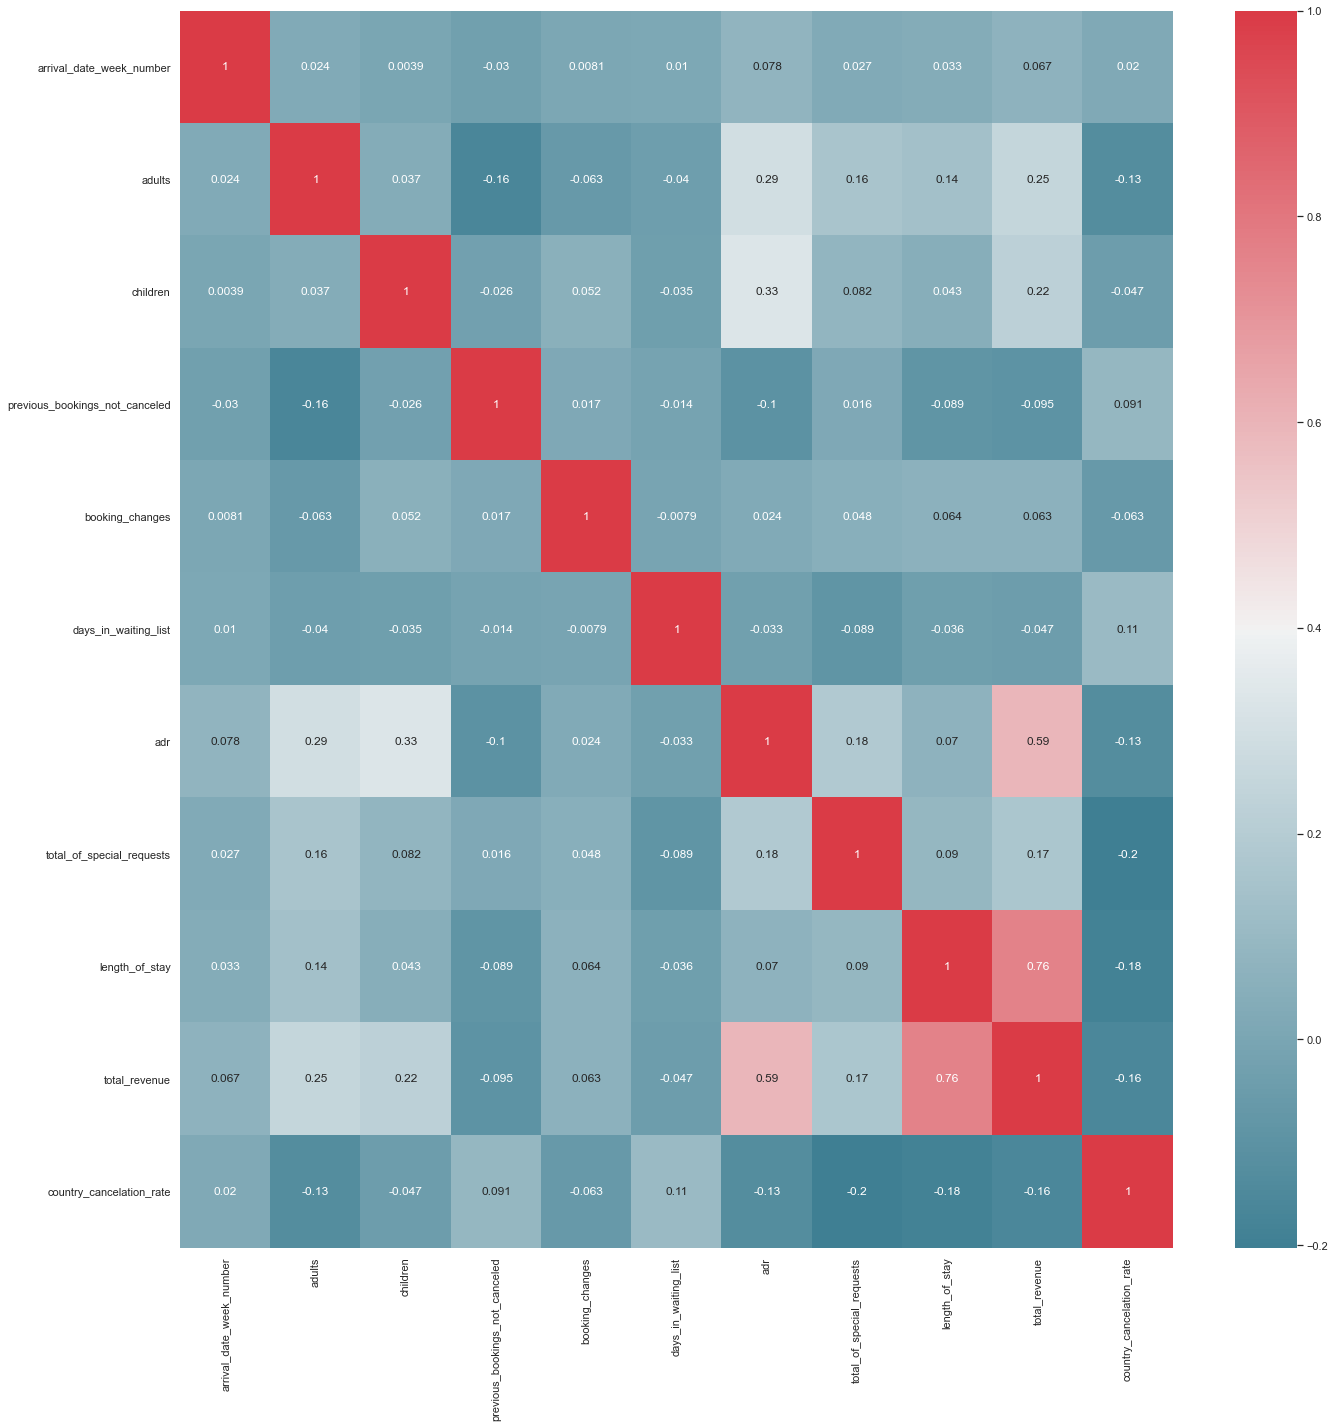

In [25]:
# plot the correlation matrix using seaborn

sns.set(style="darkgrid") # one of the many styles to plot using
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(hotel_no_outliers[hotel_continuous].corr(), cmap=cmap, annot=True)

f.tight_layout()

    # source:
    # copied from asynch notebook

Correlation Matrix:

The correlations matrix plot using the source data sans outliers tells us that there are not many strong relationships between the continuous features. We do observe some colinearity between `length_of_stay` and `total_revenue`, but that is because `total_revenue` is a product of `length_of_stay`.

Now let's check out how the pairs plot looks with all the featurest to see if there are any that provide no value in separating the classes.

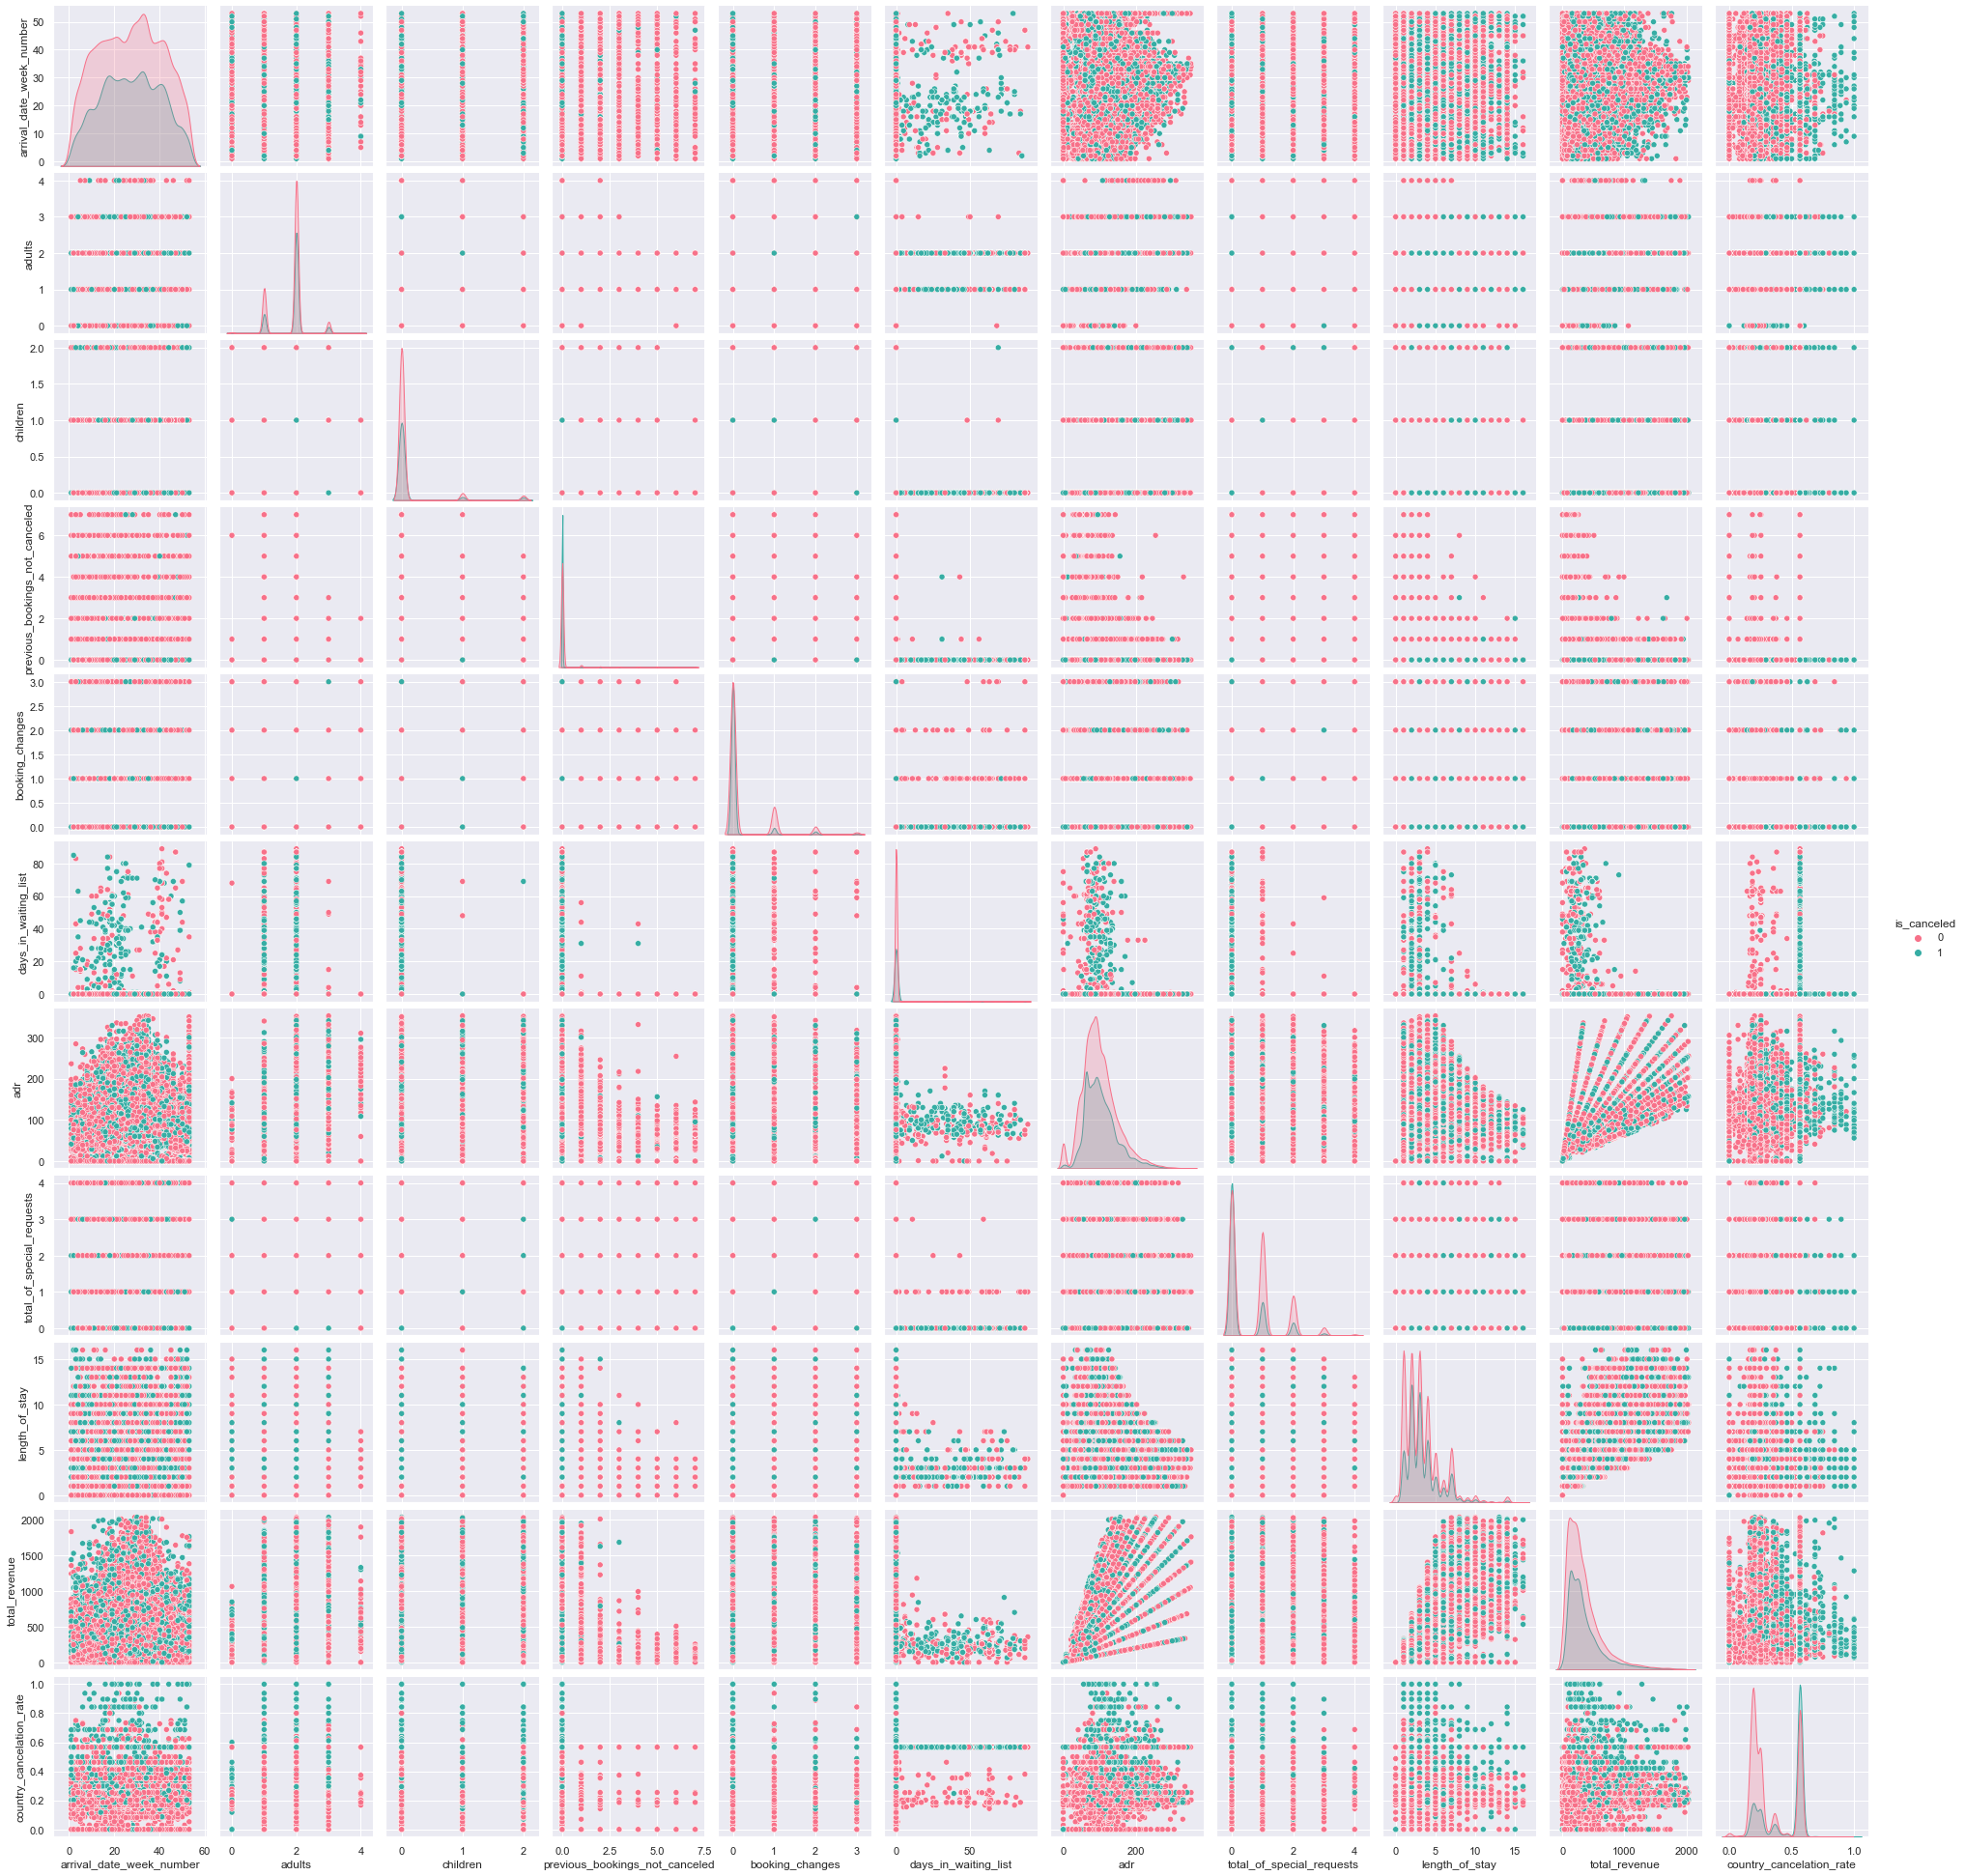

In [27]:
full_train_df = pd.concat([df_train_data_clf, df_train_target_clf], axis=1)
sns.set(color_codes=True)
var = list(hotel_no_outliers[hotel_continuous].columns)
sns.pairplot(full_train_df, hue='is_canceled', vars = var, palette="husl")

We generated a pairs plot to see if there were any good looking two-dimensional spaces in which to cluster. Though some were interesting such as the `days_in_waiting_list` vs `country_cancelation_rate`. We saw no outstanding spaces in the original features. By enriching our data with new features, we added some multicollinearity, so we decided to look into a PCA representation.

### PCA Dimension Reduction
We will use PCA as a dimensionality reduction method in order to look at our data set in 2 dimensions. This is incredibly difficult to do using the original features as we would have to choose which features to use in order to generate some two- or three-dimensional space. With the PCA we melted our features down into just the 2 principal compnents that provided the most explained variance. We will cluster in this PCA(2) space.

In [24]:
pca = PCA(2)
pca.fit(df_train_data_clf)
X_train = pd.DataFrame(pca.transform(df_train_data_clf))
X_test = pd.DataFrame(pca.transform(df_test_data_clf))
y_train = df_train_target_clf
y_test = df_test_target_clf

### Scaling the Data
Keeping our test and training sets separate and scaling them independently will help us avoid data snooping.

In [25]:
def scale_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    applies standard scaler (z-scores) to training data and predicts z-scores for the test set
    """
    scaler = StandardScaler()
    to_scale = [col for col in X_train.columns.values]
    scaler.fit(X_train[to_scale])
    X_train[to_scale] = scaler.transform(X_train[to_scale])
    
    # predict z-scores on the test set
    X_test[to_scale] = scaler.transform(X_test[to_scale])

    return X_train, X_test

X_train, X_test = scale_features(X_train, X_test)

### Describe the final dataset that is used for classification/regression

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93057 entries, 0 to 93056
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       93057 non-null  float64
 1   1       93057 non-null  float64
dtypes: float64(2)
memory usage: 1.4 MB


Having reduced our final data set to 2 principal components, our final data description is pretty simple. Below is a snapshot of the data reduced down to our 2 principal components.

In [27]:
X_train.head(10)

,0,1
0,-0.899807,0.115045
1,-0.278311,-0.152331
2,-0.716574,-0.362184
3,-0.632433,-0.107796
4,-0.521696,-0.574659
5,3.699354,-1.206384
6,0.194587,-0.159606
7,0.890434,0.673200
8,1.248827,-2.277335
9,0.835702,0.613266


# Modeling and Evaluation
### Part 1 - Train and Adjust Parameters

#### Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?) Explain why your chosen method is appropriate or use more than one method as appropriate.

`StratifiedShuffleSplit` - used to split the classification data into train/test sets. Stratifying the split to ensure class balance remains (~30% cancel/70% not cancel).

`StratifiedKFold` - with 10-fold cross validation for each fold. Stratifying the folds to ensure class balance remains (~30% cancel/70% not cancel).


Splitting the data is as follows:
```python
# classification task
# using StratifiedShuffleSplit to split into train/test sets to maintain class balance for classification task.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=24)

# converting to numpy arrays
data_Array_clf, target_Array_clf = data_clf.to_numpy(), target_clf.to_numpy()

# split into training and test sets
for train_index, test_index in sss.split(data_Array_clf, target_Array_clf):
    train_data_clf, test_data_clf = data_Array_clf[train_index], data_Array_clf[test_index]
    train_target_clf, test_target_clf = target_Array_clf[train_index], target_Array_clf[test_index]
    
```

Setting CV folds objects for classification task. 

In [28]:
# classification task
cv_clf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)

### Setting up some helper functions
Setting up a helper function to perform grid search on muliple models. We will pass it the model, its grid parameters to search, and the scoring method such as `v_measure_score` for our clustering models, and `f1` for our classification model.

In [29]:
def grid_search(model, grid, score):
    # define search
    search_grid_search_measure = GridSearchCV(
        model, grid, scoring=score, cv=cv_clf, n_jobs=nj, verbose=1
    )

    labels_true = y_train.to_numpy()
    labels_true = np.squeeze(np.asarray(np.transpose(labels_true)))

    # perform the search
    results_grid_search_measure = search_grid_search_measure.fit(X_train, labels_true)

    return results_grid_search_measure


#### MiniBatchKMeans
For MiniBatchKMeans we have 4 sets of hyperparameters to tune:
- batch-size: how big of a batch the algorithm pulls each time
- max_iter: Number of iterations to go through until: stopping or further changes are below the tolerance
- n_init: how many times new clusters will be intialized and iterated
- reassignment ratio: Controls the number of counts until a center is reassigned.

In [30]:
# MiniBatchKMeans - kmm
cluster_kmm = MiniBatchKMeans(random_state=24, n_clusters=2)

# setting the parameters - kmm
grid_kmm = {}
grid_kmm["batch_size"] = np.arange(20, 140, 20)
grid_kmm["max_iter"] = np.arange(20, 140, 20)
grid_kmm["n_init"] = np.arange(3, 13, 2)
grid_kmm["reassignment_ratio"] = np.arange(0.01, 0.05, 0.01)

In [31]:
%%time 

kmm_results_v_measure = grid_search(
    model=cluster_kmm, grid=grid_kmm, score="v_measure_score"
)

# summarize kmm
print("Mean V Measure: %.3f" % kmm_results_v_measure.best_score_)
print("Config V Measure: %s" % kmm_results_v_measure.best_params_)
print(f"Best estimator: {kmm_results_v_measure.best_estimator_}\n")


# setting the best paramaters for kmm
clf_kmm = kmm_results_v_measure.best_estimator_

Fitting 10 folds for each of 720 candidates, totalling 7200 fits
Mean V Measure: 0.001
Config V Measure: {'batch_size': 20, 'max_iter': 20, 'n_init': 5, 'reassignment_ratio': 0.01}
Best estimator: MiniBatchKMeans(batch_size=20, max_iter=20, n_clusters=2, n_init=5,
                random_state=24)

Wall time: 1min 42s


#### KMeans
For KMeans we have 2 sets of hyperparameters to tune:
- max_iter: Number of iterations to go through until: stopping or further changes are below the tolerance
- n_init: how many times new clusters will be intialized and iterated

In [32]:
# kmeans
cluster_km = KMeans(random_state=24, n_clusters=2)

# setting the parameters - kmeans
grid_km = {}
grid_km["max_iter"] = np.arange(20, 140, 20)
grid_km["n_init"] = np.arange(3, 13, 2)

In [33]:
%%time 

km_results_v_measure = grid_search(
    model=cluster_km, grid=grid_km, score="v_measure_score"
)

# summarize kmeans
print("Mean V Measure: %.3f" % km_results_v_measure.best_score_)
print("Config V Measure: %s" % km_results_v_measure.best_params_)
print(f"Best estimator: {km_results_v_measure.best_estimator_}\n")


# setting the best paramaters for kmeans
clf_km = km_results_v_measure.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Mean V Measure: 0.000
Config V Measure: {'max_iter': 20, 'n_init': 5}
Best estimator: KMeans(max_iter=20, n_clusters=2, n_init=5, random_state=24)

Wall time: 16.8 s


#### Birch
For Birch we have 2 sets of hyperparameters to tune:
 - threshold: the minimum distance between subclusters before they are merged, otherwise a new subcluster is created.
 - branching factor: Maximum number of subclusters in each node

In [34]:
# birch
cluster_bir = Birch(n_clusters=2)

# setting the parameters - birch
grid_bir = {}
grid_bir["threshold"] = np.arange(0.50, 2, 0.5)
grid_bir["branching_factor"] = np.arange(10, 60, 20)

In [35]:
%%time 

bir_results_v_measure = grid_search(
    model=cluster_bir, grid=grid_bir, score="v_measure_score"
)

# summarize birch
print("Mean V Measure: %.3f" % bir_results_v_measure.best_score_)
print("Config V Measure: %s" % bir_results_v_measure.best_params_)
print(f"Best estimator: {bir_results_v_measure.best_estimator_}\n")


# setting the best paramaters for birch
clf_bir = bir_results_v_measure.best_estimator_

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Mean V Measure: 0.001
Config V Measure: {'branching_factor': 50, 'threshold': 0.5}
Best estimator: Birch(n_clusters=2)

Wall time: 21 s


#### Decision Tree
To classify the clusters with.

In [36]:
# decision tree
clf_decision = tree.DecisionTreeClassifier(random_state=24)

# setting the parameters - dc
grid_dc = {}
grid_dc["criterion"] = ["gini", "entropy"]
grid_dc["splitter"] = ["best", "random"]
grid_dc["max_features"] = ["auto", "sqrt", "log2"]

In [37]:
%%time 

dc_results_v_measure = grid_search(model=clf_decision, grid=grid_dc, score="f1")

# summarize dc
print("Mean f1 Measure: %.3f" % dc_results_v_measure.best_score_)
print("Config f1 Measure: %s" % dc_results_v_measure.best_params_)
print(f"Best estimator: {dc_results_v_measure.best_estimator_}\n")


# setting the best paramaters for dc
clf_dc = dc_results_v_measure.best_estimator_

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Mean f1 Measure: 0.688
Config f1 Measure: {'criterion': 'gini', 'max_features': 'auto', 'splitter': 'random'}
Best estimator: DecisionTreeClassifier(max_features='auto', random_state=24, splitter='random')

Wall time: 2.4 s


### Part 2 - Evaluation and Compare

### Experimentation

We chose to use Decision Tree for classification for this problem because it is extremely fast and has proven to be the most effective classifier for this data set when compared to knn, nearest centroid, and naive bayes in previous experiments.

<img align="left" src="https://raw.githubusercontent.com/bensonnd/msds/master/ds7331/data/roc_AUC_clf.png" />  
  <br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
To run our experiments, we will build a Decision Tree model on 4 datasets using 3 clusters - KMeans, MiniBatchKMeans, and Birch:

    Dataset with no clustering information(base)
    Dataset with “clusters” as a feature (cluster-feature)
    Dataset for df[“clusters”] == 0 (clusters-0)
    Dataset for df[“clusters”] == 1 (clusters-1)

Our study is a 3x4 between-groups design with dataset [base, cluster-feature, clusters-0, clusters-1] and cluster tyoes as the only factors.

### Predicting with Clustering
A function to use our cluster models after applying GridSearchCV against our hyperparameters. We will pass the our clustering model, scaled X_train and X_test, as well as the train and test targets in order to predict as source data for our hyper parameter tuned Decision Tree model.

In [38]:
def cluster_predict(model, X_train, X_test, y_train, y_test):
    
    def get_clusters(
       model, X_train: pd.DataFrame, X_test: pd.DataFrame, n_clusters: 2
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        
        model.fit(X_train)
        
        # apply the labels
        train_labels = model.labels_
        X_train_clstrs = X_train.copy()
        X_train_clstrs["clusters"] = train_labels

        # predict labels on the test set
        test_labels = model.predict(X_test)
        X_test_clstrs = X_test.copy()
        X_test_clstrs["clusters"] = test_labels

        return X_train_clstrs, X_test_clstrs

    X_train_clstrs, X_test_clstrs = get_clusters(model, X_train, X_test, 2)

    # X_train_scaled, X_test_scaled = scale_features(X_train_clstrs, X_test_clstrs)
    X_train_scaled, X_test_scaled = X_train_clstrs, X_test_clstrs

    # to divide the df by cluster, we need to ensure we use the correct class labels, we'll use pandas to do that
    train_clusters = X_train_scaled.copy()
    test_clusters = X_test_scaled.copy()
    train_clusters['y'] = y_train
    test_clusters['y'] = y_test

    # locate the "0" cluster
    train_0 = train_clusters.loc[train_clusters.clusters == 0] # after scaling, 0 went negative
    test_0 = test_clusters.loc[test_clusters.clusters == 0]
    y_train_0 = train_0.y.values
    y_test_0 = test_0.y.values

    # locate the "1" cluster
    train_1 = train_clusters.loc[train_clusters.clusters == 1] # after scaling, 1 dropped slightly
    test_1 = test_clusters.loc[test_clusters.clusters == 1]
    y_train_1 = train_1.y.values
    y_test_1 = test_1.y.values

    # the base dataset has no "clusters" feature
    X_train_base = X_train_scaled.drop(columns=['clusters'])
    X_test_base = X_test_scaled.drop(columns=['clusters']) # drop the targets from the training set


    X_train_0 = train_0.drop(columns=['y'])
    X_test_0 = test_0.drop(columns=['y'])
    X_train_1 = train_1.drop(columns=['y'])
    X_test_1 = test_1.drop(columns=['y'])
    datasets = {
        'base': (X_train_base, y_train, X_test_base, y_test),
        'cluster-feature': (X_train_scaled, y_train, X_test_scaled, y_test),
        'clusters-0': (X_train_0, y_train_0, X_test_0, y_test_0),
        'clusters-1': (X_train_1, y_train_1, X_test_1, y_test_1),
    }

    def run_exps(datasets: dict) -> pd.DataFrame:
        '''
        runs experiments on a dict of datasets
        '''
        # our decision tree model, after hyper paramater tuning with GridSearchCV
        model = clf_dc
        
        dfs = []
        results = []
        conditions = []
        scoring = ['accuracy','precision_weighted','recall_weighted','f1_weighted']
        models = []
        datasets_model = {}
        for condition, splits in datasets.items():
            X_train = splits[0]
            y_train = splits[1]
            X_test = splits[2]
            y_test = splits[3]
            
            # using our cv object for 10-fold StratifiedKFold cross validation
            kfold = cv_clf
            cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
            clf = model.fit(X_train, y_train)
            models.append(clf)
            y_pred = clf.predict(X_test)
            results.append(cv_results)
            conditions.append(condition)
            this_df = pd.DataFrame(cv_results)
            this_df['condition'] = condition
            dfs.append(this_df)
            final = pd.concat(dfs, ignore_index=True)
            
            datasets_model[condition] = [splits,clf]
        
        # We have wide format data, lets use pd.melt to fix this
        results_long = pd.melt(final,id_vars=['condition'],var_name='metrics', value_name='values')
        
        # fit time metrics, we don't need these
        time_metrics = ['fit_time','score_time'] 
        results = results_long[~results_long['metrics'].isin(time_metrics)] # get df without fit data
        results = results.sort_values(by='values')
        

        
        return results, datasets_model
    return run_exps(datasets)

# source - https://towardsdatascience.com/cluster-then-predict-for-classification-tasks-142fdfdc87d6

Helper functions to organize the output of the `cluster_predict` function.

In [39]:
def cluster_predict_df(name, model):
    return cluster_predict(model, X_train, X_test, y_train, y_test)

def cluster_eval(name, model):
    df, _, = cluster_predict_df(name, model)
    table = pd.pivot_table(
        df,
        index="condition",
        columns=["metrics"],
        values=["values"],
        aggfunc="mean",
    )
    
    return table

#### MiniBatchKMeans

In [40]:
kmm_table = cluster_eval("MiniBatchKMeans", clf_kmm)
display(kmm_table)

values                                           \
metrics         test_accuracy test_f1_weighted test_precision_weighted   
condition                                                                
base                 0.766670         0.767076                0.767581   
cluster-feature      0.765488         0.765940                0.766509   
clusters-0           0.797475         0.797817                0.798249   
clusters-1           0.642780         0.644026                0.645624   

                                      
metrics         test_recall_weighted  
condition                             
base                        0.766670  
cluster-feature             0.765488  
clusters-0                  0.797475  
clusters-1                  0.642780

The table shows cluster-0 as the clearly superior configuration for the classification. Base and cluster-feature are quite close behind cluster-0. Cluster-1 is awful across the board.

#### KMeans

In [41]:
km_table = cluster_eval("KMeans", clf_km)
display(km_table)

values                                           \
metrics         test_accuracy test_f1_weighted test_precision_weighted   
condition                                                                
base                 0.766670         0.767076                0.767581   
cluster-feature      0.765692         0.766251                0.766967   
clusters-0           0.635543         0.636256                0.637268   
clusters-1           0.789687         0.789990                0.790404   

                                      
metrics         test_recall_weighted  
condition                             
base                        0.766670  
cluster-feature             0.765692  
clusters-0                  0.635543  
clusters-1                  0.789687

Cluster-1 here provides the best classification metrics. The exact opposite of the MiniBatch and Birch.

#### Birch

In [42]:
bir_table = cluster_eval("Birch", clf_bir)
display(bir_table)

values                                           \
metrics         test_accuracy test_f1_weighted test_precision_weighted   
condition                                                                
base                 0.766670         0.767076                0.767581   
cluster-feature      0.764564         0.765086                0.765749   
clusters-0           0.786129         0.786422                0.786815   
clusters-1           0.671365         0.671971                0.672913   

                                      
metrics         test_recall_weighted  
condition                             
base                        0.766670  
cluster-feature             0.764564  
clusters-0                  0.786129  
clusters-1                  0.671365

Birch was comparable with MiniBatch KMeans. Their scores for cluster-0 were close and they both found little use for cluster-1. Outside of a few outliers Birch's cluster-0 provide a narrower range then other methods.

### Overall Summary
In comparing the clustering results scores, we found the highest f1-score for each respective method:

    -MiniBatchKMeans: .7978 (clusters-0)
    -KMeans:          .7899 (clusters-1)
    -Birch:           .7864 (clusters-0)

As you can see, at their best they all performed relatively similar. The highest performer of the three looks to be MiniBatchKmeans on the clusters-0 condition. This means that in using the cluster which assumed the 'is_canceled' label of 0 to make our predictions of classes in the decision tree algorithm, it actually made better class predictions than its rivals. This is obviously surprising, as it worked best with less information. Although its clusters don't know the true classes when they make their classifications, so the 0 cluster likely contained representations from both classes. This is why our V-Measure was not great.

Now that we have our winner based on the f1 performance, we will also take a look at the ROC curves later on to validate our findings using the AUC.

### Part 3 - Visualize results
A helper function to easily plot our clusters from our PCA data set.

In [43]:
def plot_pca(model):
    model.fit(X_train)
    labels = model.predict(X_test)

    #filter rows of original data
    filtered_label0 = X_test[labels == 0]
    filtered_label0 = filtered_label0.to_numpy()
    filtered_label1 = X_test[labels == 1]
    filtered_label1 = filtered_label1.to_numpy()

    #Plotting the results
    plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red')
    plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'black')
    plt.show()

#### MiniBatchKMeans

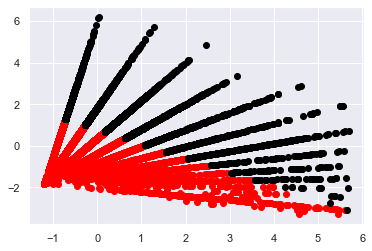

In [44]:
plot_pca(clf_kmm)

MiniBatch KMeans places the cluster-0 on the bottom of the graph we have started calling the 'porcupine'. Anything out into the quills was grouped as cluster-1. This appears to cluster similar to our class balance of approximately 30%/70% for cancelations.

#### KMeans

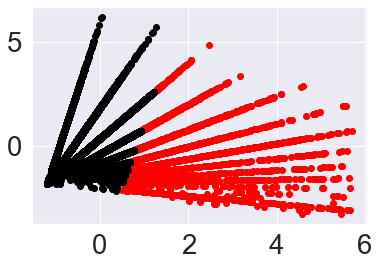

In [62]:
plot_pca(clf_km)

KMeans gave us a left/right split of the data, rather than a top/bottom split like that of the MiniBatch. It would appear that most of our cancelations are in the bottom left corner, as whatever cluster takes that area provides the best metrics.

#### Birch

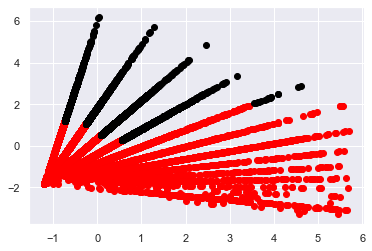

In [46]:
plot_pca(clf_bir)

Birch did not seem to give as clean of a split between clusters as the other two. This method clustered the bottom as well as the right most quills together as cluster-0 and the top/left-most quills as cluster-1 with some inclusion of the top middle. Below we will see this is the worst performing classification, however it still finds the bottom to be the best predictor.

A helper function to plot and organize our output from the `cluster_predict` function noted above.

In [47]:
def plot_cluster_predictions_boxplots(name, model):
    df, _ = cluster_predict_df(name, model)
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="condition", y="values", hue="metrics", data=df, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(f'Comparison of Dataset by Classification Metric - {name}')  


#### MiniBatchKMeans

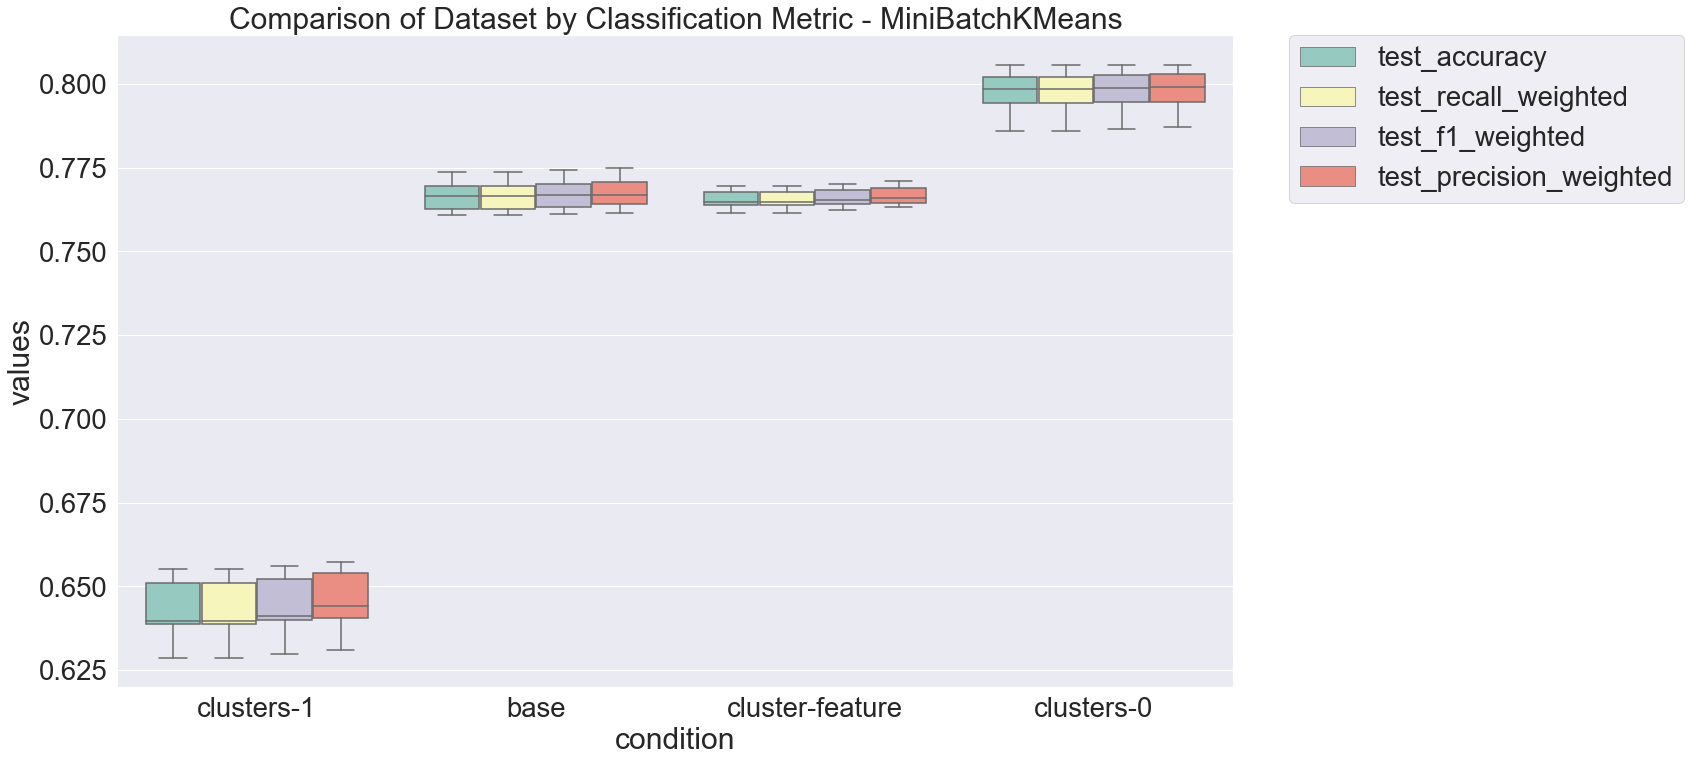

In [48]:
plot_cluster_predictions_boxplots("MiniBatchKMeans", clf_kmm)

Cluster-1 had the lowest classification metrics and relatively large variance when compared with the other configurations. the base and cluster-feature configurations were quite close. Cluster-feature had narrower scores but base had the higher metrics. cluster-0 (the bottom of the porcupine) had the best metrics by far here. Even the minimums were above the rest.

#### KMeans

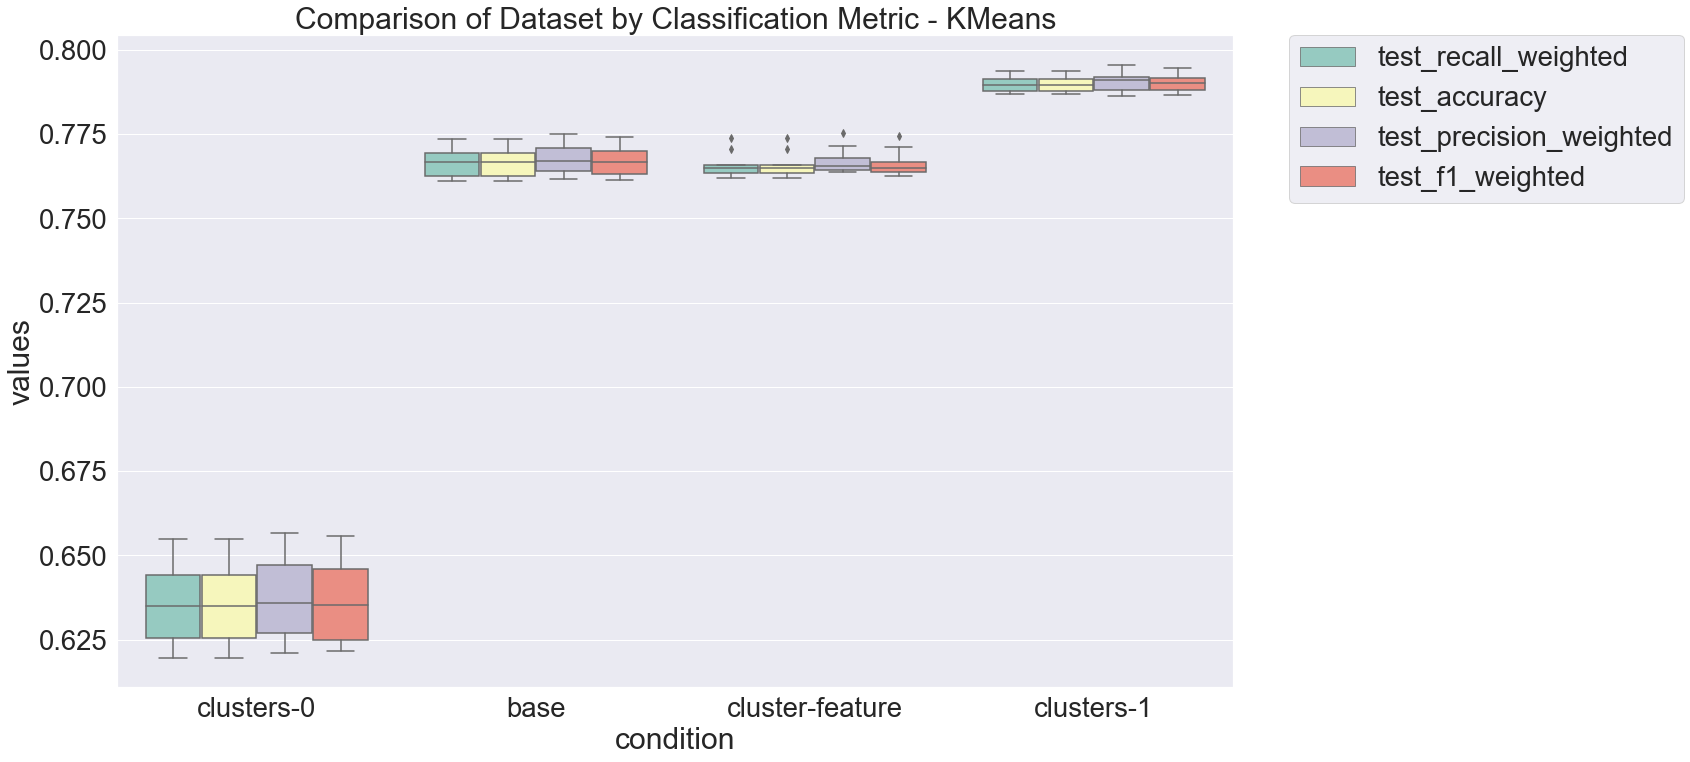

In [49]:
plot_cluster_predictions_boxplots("KMeans", clf_km)

KMeans is the inverse mirror image of MiniBatch regarding clustering effectiveness at prediction. Cluster-1 and Cluster-0 switched places. This corresponds with the switch in clustering that was shown in the 'porcupine' graph above.

#### Birch

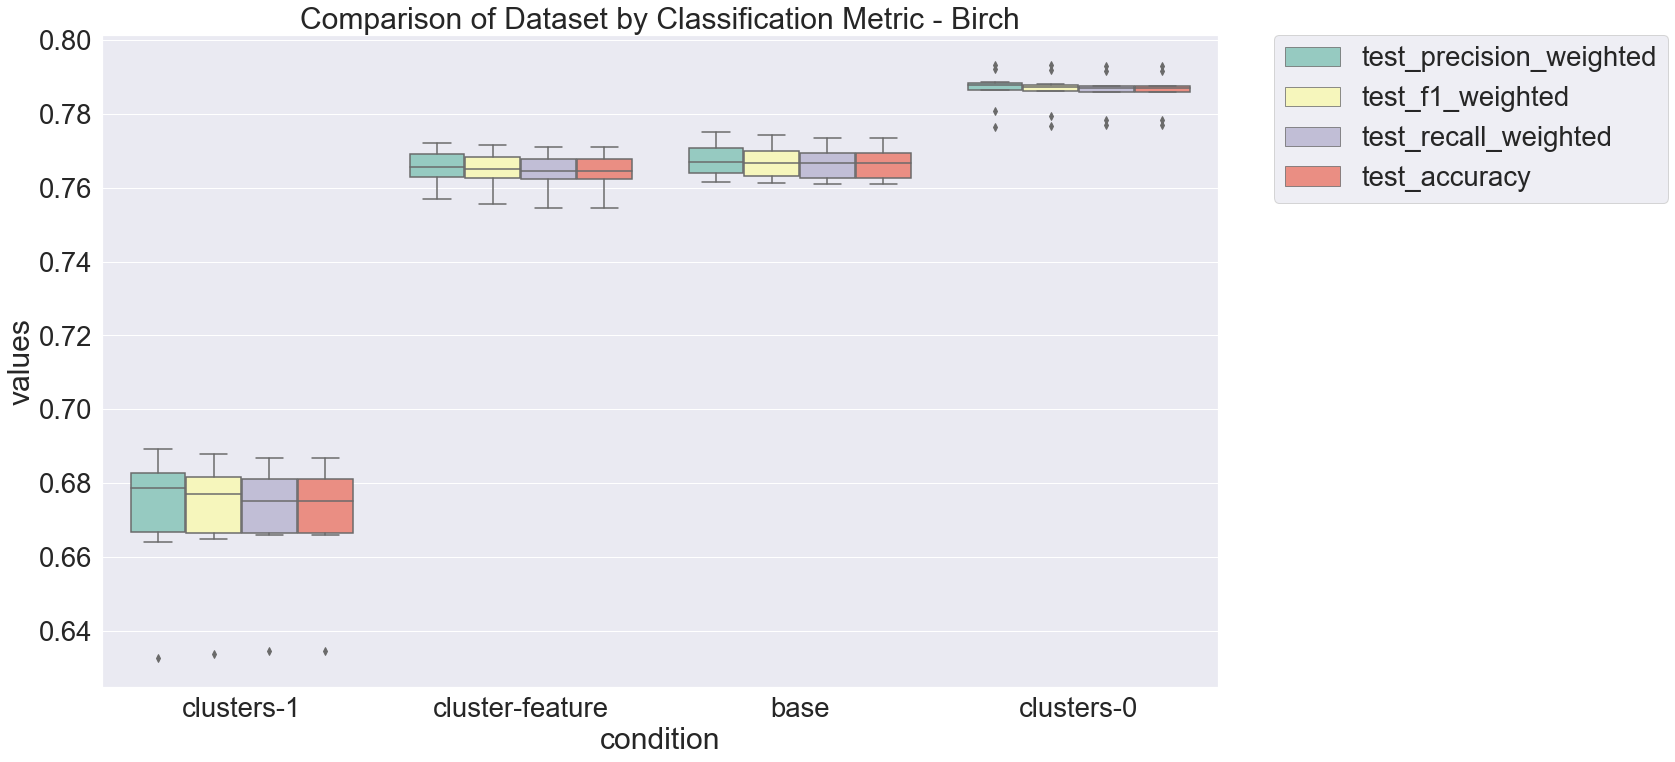

In [50]:
plot_cluster_predictions_boxplots("Birch", clf_bir)

Like MiniBatch, Birch had the cluster-0 configuration as its best performing. It is interesting to note that the both MiniBatch and Birch clustering method made use of the cluster-0 configuration.

### Part 4 - Summarize the Ramifications

In [51]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

#### ROC and AUC Evaluation
In order to plot ROC Decision Tree, an ensemble method called bagging must be employed to get prediction probabilities for plotting.

In [52]:
def plot_roc_curves(models):
    
    for key, value in models.items():
        #bagging to get probabilities for an ROC curve for Decision Tree
        y_train = value[0][1]
        
        if isinstance(y_train, pd.DataFrame):
            y_train = y_train.to_numpy().ravel()

        clf_bag_dtree_acc = BaggingClassifier(base_estimator=value[1], 
                                              random_state=24).fit(value[0][0], y_train)

        # plot the ROC curve on the test data for Decision Tree
        Y_pred_dtree_acc_prob = clf_bag_dtree_acc.predict_proba(value[0][2])[::,1]
        fpr_dtree_acc, tpr_dtree_acc, _ = metrics.roc_curve(value[0][3],  Y_pred_dtree_acc_prob)
        auc_dtree_acc = metrics.roc_auc_score(value[0][3], Y_pred_dtree_acc_prob)
        plt.plot(fpr_dtree_acc,tpr_dtree_acc,label=f"{key}, auc= {str(auc_dtree_acc)}")
    
    plt.legend(loc="lower right", prop={'size':10})

#### MiniBatchKMeans

In [53]:
_, kmm_models = cluster_predict_df("MiniBatchKMeans", clf_kmm)

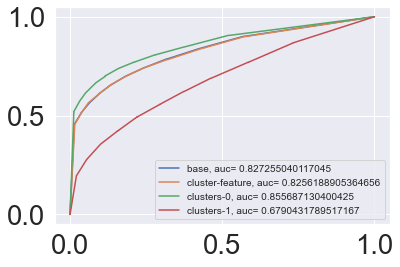

In [54]:
plot_roc_curves(kmm_models)

The ROC curves for MiniBatchKMeans show the best area under curve (AUC) at .855 for clusters-0, which matches our best f1-score mentioned earlier.

#### KMeans

In [55]:
_, km_models = cluster_predict_df("KMeans", clf_km)

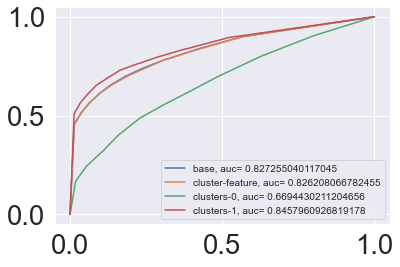

In [56]:
plot_roc_curves(km_models)

The ROC curves for KMeans show the best area under curve (AUC) at .845 for clusters-1.

#### Birch

In [57]:
_, bir_models = cluster_predict_df("Birch", clf_bir)

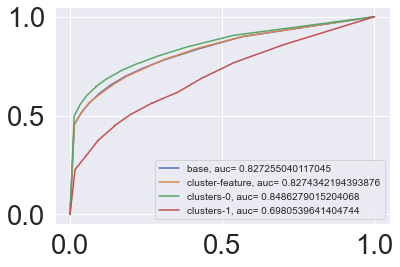

In [58]:
plot_roc_curves(bir_models)

The ROC curves for Birch show the best area under curve (AUC) at .848 for clusters-0.

### Overall Conclusion
Looking across all three clustering types, we see that MiniBatch KMeans clustering with clusters-0 dataset and prediction using Decision Tree, is the best performing clustering algorithm with an AUC of 0.8556 for our prediction needs of cancel vs no cancel.

In conclusion, using clustering to predict cancelations did not perform as well as just using classifiers for classification. Clustering may not be appropriate with our data set, given that the class is already labeled. Supervised learning outperformed clustering for classification.

Our previous experiments with supervised learning for classification produced and AUC of 0.9364 compared our clustering in which we see a max AUC of 0.8556.

# Deployment

#### Did you achieve your goals?
Yes we did. We set out to see if clustering could be used to help classify our dataset and we were successful in using it to do that. The clustering methods used did lower dimensionality and speed some methods up. However, the clustering did not add any significant amount of useful predictability, in fact we saw a decline in prediction performance. It also further obfuscated the original features. If explaining the model were important this method would make it quite difficult.

#### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?
The use of clustering did not out perform the best classification configuration from our previous work. The clustering could likely be left out in favor of the normal features and classification methods.

####  How would your deploy your model for interested parties?
In a production environment, it would make sense to have the model run against each new reservation as it comes in, and then classify it as potential cancel or not. This should be as near real time as possible in order to manage inventory properly.

####  What other data should be collected?
Missing from this data is the obvious PII such as any sort of information related to customer. Obfuscated data would be sufficient, and in fact individual level data might significantly increase the accuracy of the model. Any other information about how a customer felty about their stay would be useful as well. Satisfaction ratings or surveys would be useful tool in determining furture stays and probability of cancelations

####  How often would the model need to be updated, etc.?
A monthly update on the model should be sufficient. Updates to the model can be made in non-production environments on production level data, and then dedployed as needed. Deployments should only happen at low traffic times.

# Exceptional Work

### Bagging/Ensembling - Decision Tree ROC, AUC
<ul>Decision Tree ROC</ul>

In [59]:
def plot_roc_curves(models):
    
    for key, value in models.items():
        #bagging to get probabilities for an ROC curve for Decision Tree
        y_train = value[0][1]
        
        if isinstance(y_train, pd.DataFrame):
            y_train = y_train.to_numpy().ravel()

        clf_bag_dtree_acc = BaggingClassifier(base_estimator=value[1], 
                                              random_state=24).fit(value[0][0], y_train)

        # plot the ROC curve on the test data for Decision Tree
        Y_pred_dtree_acc_prob = clf_bag_dtree_acc.predict_proba(value[0][2])[::,1]
        fpr_dtree_acc, tpr_dtree_acc, _ = metrics.roc_curve(value[0][3],  Y_pred_dtree_acc_prob)
        auc_dtree_acc = metrics.roc_auc_score(value[0][3], Y_pred_dtree_acc_prob)
        plt.plot(fpr_dtree_acc,tpr_dtree_acc,label=f"{key}, auc= {str(auc_dtree_acc)}")
    
    plt.legend(loc="lower right", prop={'size':10})

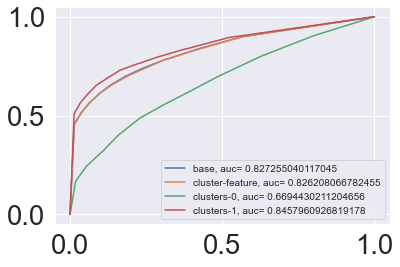

In [60]:
plot_roc_curves(km_models)

### Advanced Feature Engineering
Calculated the per country cancelation rate and joined it back to the original data at the reservation level.

```python
# add `country_cancelation_rate`
    # first we aggregate number of cancelations per country, then divide by total records per country
    # once we have the rate, we join back on country name
hotel['is_canceled_int'] = pd.to_numeric(hotel['is_canceled'])

contry_cancellation_rate_df = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].count())

contry_cancellation_rate_df.columns = ['country_count']
contry_cancellation_rate_df['cancelations'] = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].sum())

contry_cancellation_rate_df['country_cancelation_rate'] = contry_cancellation_rate_df['cancelations'] / contry_cancellation_rate_df['country_count']

hotel = hotel.join(contry_cancellation_rate_df, on='country')

total_cancelations = hotel.is_canceled_int.sum()
````